In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdocan/monthly-ice-cream-sales-data-1972-2020")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 3.84k/3.84k [00:00<00:00, 1.31MB/s]

Extracting files...
Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\abdocan\monthly-ice-cream-sales-data-1972-2020\versions\1


            IPN31152N
DATE                 
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636


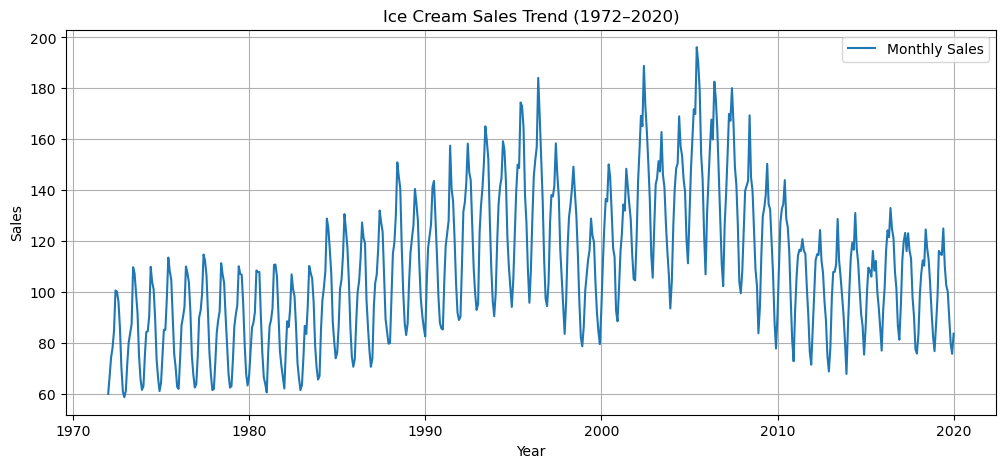

Linear Regression MSE: 0.000
Random Forest MSE: 26.580
XGBoost MSE: 23.431

Best Model: Linear Regression


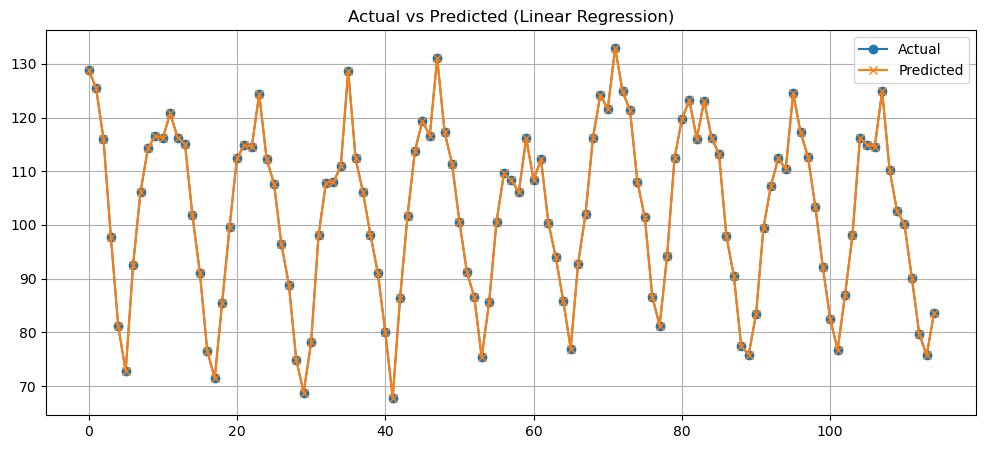


📌 Next 12-Month Sales Forecast:
       Date  Forecasted Sales
0   2020-02           83.6290
1   2020-03           79.7223
2   2020-04           75.7094
3   2020-05           83.6290
4   2020-06           79.7223
5   2020-07           75.7094
6   2020-08           83.6290
7   2020-09           79.7223
8   2020-10           75.7094
9   2020-11           83.6290
10  2020-12           79.7223
11  2021-01           75.7094


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===============================
# 1. Load Dataset
# ===============================
df = pd.read_csv("ice_cream.csv")   # change to your filename
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

print(df.head())

# Rename column for convenience
df.rename(columns={'IPN31152N': 'Sales'}, inplace=True)

# ===============================
# 2. Visualize the sales trend
# ===============================
plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='Monthly Sales')
plt.title("Ice Cream Sales Trend (1972–2020)")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.grid()
plt.legend()
plt.show()

# ===============================
# 3. Create lag features
# ===============================
df['Lag_1'] = df['Sales'].shift(1)
df['Lag_2'] = df['Sales'].shift(2)
df['Lag_3'] = df['Sales'].shift(3)

# Moving Average Features
df['MA_3'] = df['Sales'].rolling(3).mean()
df['MA_6'] = df['Sales'].rolling(6).mean()

df = df.dropna()

# ===============================
# 4. Prepare data
# ===============================
X = df[['Lag_1', 'Lag_2', 'Lag_3', 'MA_3', 'MA_6']]
y = df['Sales']

# Train–Test Split (20% test, no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ===============================
# 5. Train Models
# ===============================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    results[name] = mse
    print(f"{name} MSE: {mse:.3f}")

# ===============================
# 6. Select best model
# ===============================
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print("\nBest Model:", best_model_name)

# ===============================
# 7. Plot Actual vs Predicted
# ===============================
pred = best_model.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(pred, label="Predicted", marker='x')
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.legend()
plt.grid()
plt.show()

# ===============================
# 8. Predict next 12 months
# ===============================
future_predictions = []
last_row = df.iloc[-1:].copy()

for i in range(12):
    X_future = last_row[['Lag_1', 'Lag_2', 'Lag_3', 'MA_3', 'MA_6']]
    next_value = best_model.predict(X_future)[0]
    future_predictions.append(next_value)

    # Update lag features
    last_row['Lag_3'] = last_row['Lag_2']
    last_row['Lag_2'] = last_row['Lag_1']
    last_row['Lag_1'] = next_value
    last_row['MA_3'] = (last_row['Lag_1'] + last_row['Lag_2'] + last_row['Lag_3']) / 3
    last_row['MA_6'] = (last_row['MA_3']*3 + last_row['Lag_1'] + last_row['Lag_2'] + last_row['Lag_3']) / 6

print("\n📌 Next 12-Month Sales Forecast:")
# Create future dates for forecasting
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1),
                             periods=12, 
                             freq='MS')   # 'MS' = Month Start

future_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Sales": future_predictions
})

future_df["Date"] = pd.to_datetime(future_df["Date"]).dt.strftime("%Y-%m")

print(future_df)


In [8]:
!pip install xgboost

In [10]:
print(df.head())

               Sales     Lag_1     Lag_2     Lag_3       MA_3       MA_6
DATE                                                                    
1972-06-01  100.5960   84.7636   78.1120   74.2350  87.823867  77.454883
1972-07-01  100.1263  100.5960   84.7636   78.1120  95.161967  84.148900
1972-08-01   96.3607  100.1263  100.5960   84.7636  99.027667  89.032267
1972-09-01   85.8007   96.3607  100.1263  100.5960  94.095900  90.959883
1972-10-01   70.3934   85.8007   96.3607  100.1263  84.184933  89.673450
